In [10]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
#%matplotlib inline

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Conv2DTranspose, LeakyReLU, BatchNormalization, Activation
from keras.models import Model
from keras import losses
from keras import backend as K
from keras import metrics
from keras.datasets import fashion_mnist
from fashion_mnist.utils import mnist_reader
from keras.models import load_model

import h5py



In [2]:
FILE_PATH = "./Fashion_MNIST/"

img_rows, img_cols, img_chns = 28, 28, 1

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

In [3]:
K.image_data_format()

'channels_last'

In [4]:
x_train, y_train = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='train')
x_test, y_test = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='t10k')


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format


print('x_train shape:', x_train.shape)

print('x_test shape:', x_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


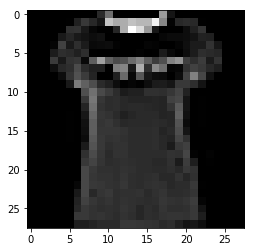

In [5]:
plt.imshow(x_train[y_train==0][6,:,:,0], cmap='gray')
plt.show()

In [6]:
def load_AE(path):
    """
    Load a autoencoder previously saved as a h5 file.
    Returns the autoencoder, the encoder and the decoders models, assuming the two latters are respectively the second and the third layer of the AE model.
    """
    autoencoder = load_model(path)
    encoder = autoencoder.layers[1]
    decoder = autoencoder.layers[2]
    return autoencoder, encoder, decoder

### Simple Convolutional AE

In [7]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img, encoded, name='encoder')

encoder.summary()

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
encoded_img = Input(shape=(4, 4, 8))  # adapt this if using `channels_first` image data format

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_img)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_img, decoded, name='decoder')

decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0         
Total para

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 86s 1ms/step - loss: 0.3752 - val_loss: 0.3386
Epoch 2/50
60000/60000 [==============================] - 85s 1ms/step - loss: 0.3263 - val_loss: 0.3268
Epoch 3/50
60000/60000 [==============================] - 85s 1ms/step - loss: 0.3156 - val_loss: 0.3133
Epoch 4/50
60000/60000 [==============================] - 86s 1ms/step - loss: 0.3103 - val_loss: 0.3095
Epoch 5/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.3066 - val_loss: 0.3078
Epoch 6/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.3037 - val_loss: 0.3003
Epoch 7/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.3017 - val_loss: 0.3055
Epoch 8/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.3000 - val_loss: 0.3024
Epoch 9/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.2986 - val_loss: 0.2982
Epoch

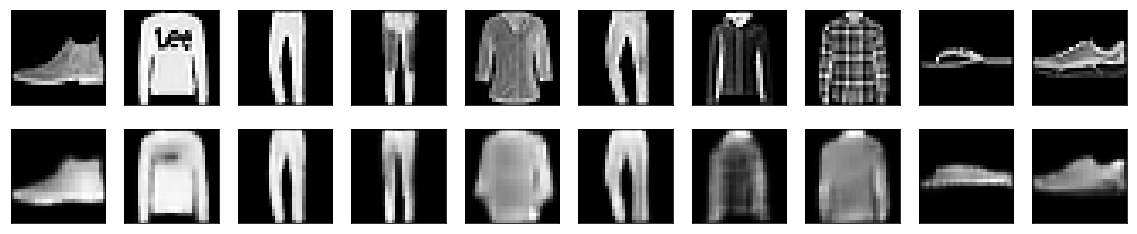

In [9]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    encoded_x_test = encoder.predict(x_test[i].reshape((1,28,28,1)))
    decoded_x_test = decoder.predict(encoded_x_test)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_x_test[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [34]:
x_test.shape

(10000, 28, 28, 1)

In [43]:
H = encoder.predict(x_test)
H = H.reshape((len(x_test), np.prod(H.shape[1:])))

W = np.dot(np.linalg.pinv(H), x_test.reshape((x_test.shape[0], img_rows*img_cols)))
W = W.reshape((W.shape[0], img_rows, img_cols))

W.shape

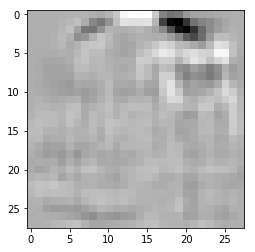

In [27]:
plt.imshow(W[i])


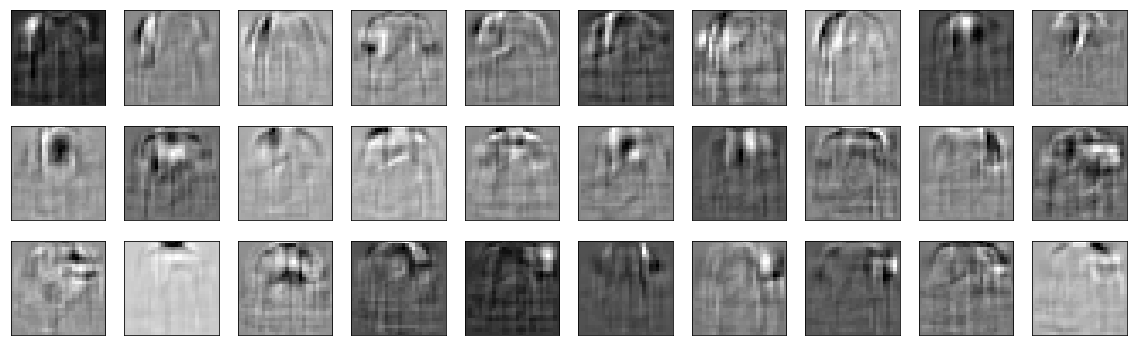

In [32]:
n = 30  # how many basis images we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(W[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
autoencoder.save('./convAE_simple128.h5')

### Adding a dense layer

In [36]:
latent_dim = 10

In [41]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)

encoded = Dense(latent_dim)(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()
# at this point the representation is latent_dim-dimensional
encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(128)(encoded_img)
x = Reshape((4,4,8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 4, 4, 8)           0         
__________

In [42]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 90s 2ms/step - loss: 0.3805 - val_loss: 0.3331
Epoch 2/50
60000/60000 [==============================] - 92s 2ms/step - loss: 0.3305 - val_loss: 0.3243
Epoch 3/50
60000/60000 [==============================] - 87s 1ms/step - loss: 0.3214 - val_loss: 0.3183
Epoch 4/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3160 - val_loss: 0.3146
Epoch 5/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3122 - val_loss: 0.3114
Epoch 6/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3094 - val_loss: 0.3122
Epoch 7/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3073 - val_loss: 0.3105
Epoch 8/50
60000/60000 [==============================] - 80s 1ms/step - loss: 0.3055 - val_loss: 0.3045
Epoch 9/50
60000/60000 [==============================] - 80s 1ms/step - loss: 0.3045 - val_loss: 0.3070
Epoch

In [52]:
autoencoder.save('./convAE_dense1.h5')

In [8]:
autoencoder, encoder, decoder = load_AE('./Models/convAE_dense1.h5')

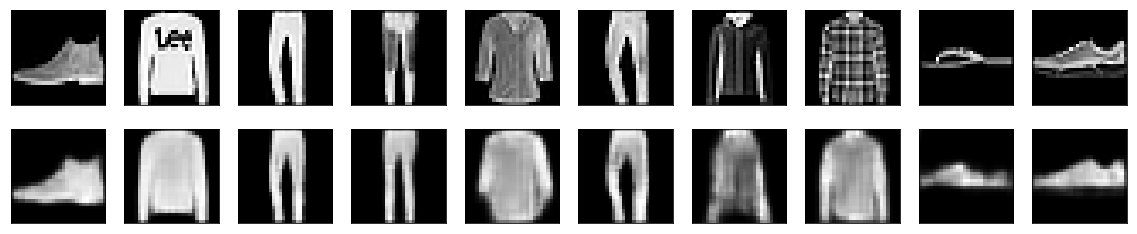

In [47]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    encoded_x_test = encoder.predict(x_test[i].reshape((1,28,28,1)))
    decoded_x_test = decoder.predict(encoded_x_test)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_x_test[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
H = encoder.predict(x_test)
H = H.reshape((len(x_test), np.prod(H.shape[1:])))

W = np.dot(np.linalg.pinv(H), x_test.reshape((x_test.shape[0], img_rows*img_cols)))
W = W.reshape((W.shape[0], img_rows, img_cols))

W.shape

(10, 28, 28)

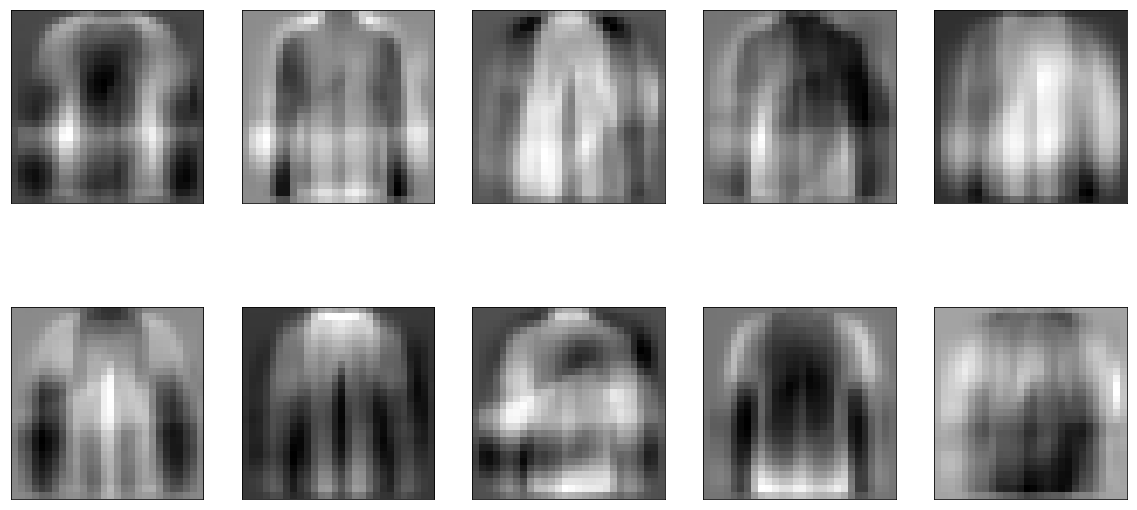

In [49]:
n = 10  # how many basis images we will display
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(W[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
X_linear_approx_test = np.dot(H, W.reshape(10, np.prod(W.shape[1:])))
X_linear_approx_test= X_linear_approx_test.reshape(len(x_test),img_rows, img_cols)

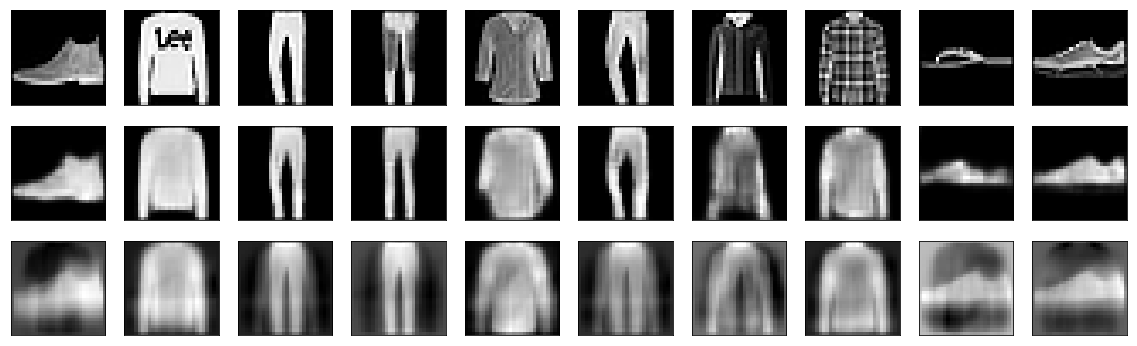

In [11]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    decoded_x_test = decoder.predict(H[i].reshape((1,10)))
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_x_test[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display linear approximation recontruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(X_linear_approx_test[i,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [12]:
np.linalg.norm(autoencoder.predict(x_test).reshape((10000, 28*28)) - X_linear_approx_test.reshape((10000, 28*28)))

397.79272

In [35]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

### Higher dimension latent space

In [13]:
latent_dim = 32

In [14]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)

encoded = Dense(latent_dim)(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()
# at this point the representation is latent_dim-dimensional
encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(128)(encoded_img)
x = Reshape((4,4,8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 8)           0         
__________

In [15]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 88s 1ms/step - loss: 0.3733 - val_loss: 0.3294
Epoch 2/50
60000/60000 [==============================] - 90s 2ms/step - loss: 0.3277 - val_loss: 0.3215
Epoch 3/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3188 - val_loss: 0.3191
Epoch 4/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3137 - val_loss: 0.3098
Epoch 5/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3097 - val_loss: 0.3111
Epoch 6/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3070 - val_loss: 0.3068
Epoch 7/50
60000/60000 [==============================] - 83s 1ms/step - loss: 0.3048 - val_loss: 0.3035
Epoch 8/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3030 - val_loss: 0.3039
Epoch 9/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3014 - val_loss: 0.3042
Epoch

In [16]:
autoencoder.save('./convAE_Simple_dense32.h5')

### 128 dimensions latent space

In [17]:
latent_dim = 128

In [18]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)

encoded = Dense(latent_dim)(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()
# at this point the representation is latent_dim-dimensional
encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(128)(encoded_img)
x = Reshape((4,4,8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 8)           0         
__________

In [19]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 88s 1ms/step - loss: 0.3734 - val_loss: 0.3313
Epoch 2/50
60000/60000 [==============================] - 87s 1ms/step - loss: 0.3201 - val_loss: 0.3181
Epoch 3/50
60000/60000 [==============================] - 88s 1ms/step - loss: 0.3112 - val_loss: 0.3113
Epoch 4/50
60000/60000 [==============================] - 89s 1ms/step - loss: 0.3067 - val_loss: 0.3042
Epoch 5/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3037 - val_loss: 0.3041
Epoch 6/50
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3013 - val_loss: 0.3036
Epoch 7/50
60000/60000 [==============================] - 94s 2ms/step - loss: 0.2996 - val_loss: 0.3019
Epoch 8/50
60000/60000 [==============================] - 89s 1ms/step - loss: 0.2979 - val_loss: 0.3009
Epoch 9/50
60000/60000 [==============================] - 89s 1ms/step - loss: 0.2970 - val_loss: 0.2966
Epoch

In [20]:
autoencoder.save('./Models/convAE_Simple_dense128.h5')

In [13]:
autoencoder, encoder, decoder = load_AE('./Models/convAE_Simple_dense128.h5')

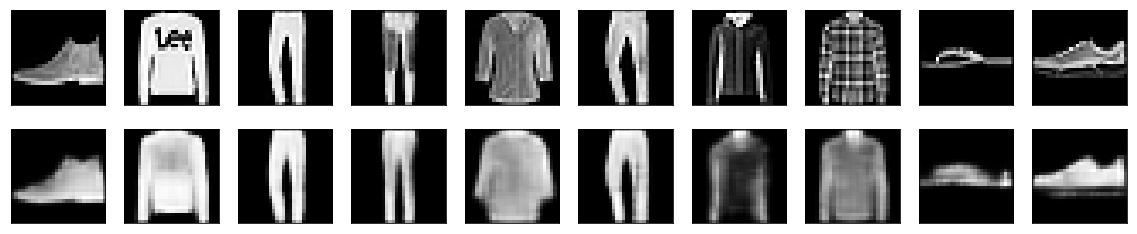

In [14]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    encoded_x_test = encoder.predict(x_test[i].reshape((1,28,28,1)))
    decoded_x_test = decoder.predict(encoded_x_test)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_x_test[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
H = encoder.predict(x_test)
H = H.reshape((len(x_test), np.prod(H.shape[1:])))

W = np.dot(np.linalg.pinv(H), x_test.reshape((x_test.shape[0], img_rows*img_cols)))
W = W.reshape((W.shape[0], img_rows, img_cols))

W.shape

(128, 28, 28)

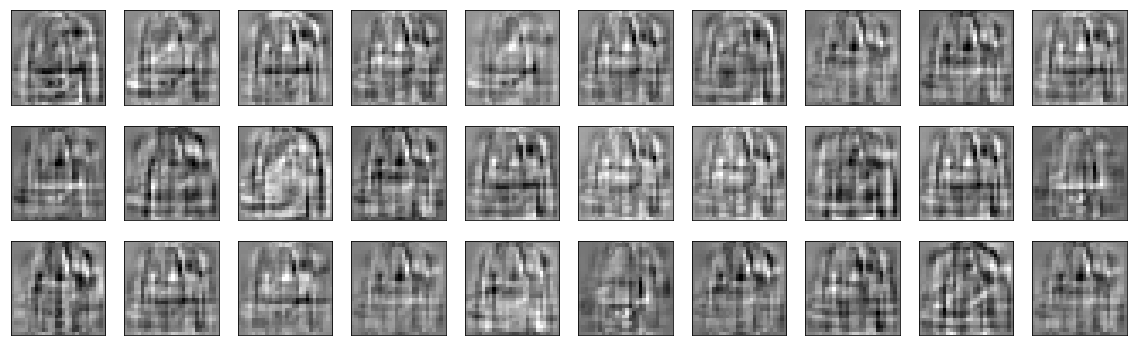

In [26]:
n = 30  # how many basis images we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(W[i*2])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
X_linear_approx_test = np.dot(H, W.reshape(128, np.prod(W.shape[1:])))
X_linear_approx_test= X_linear_approx_test.reshape(len(x_test),img_rows, img_cols)

In [35]:
X_linear_approx_test.shape

(10000, 28, 28)

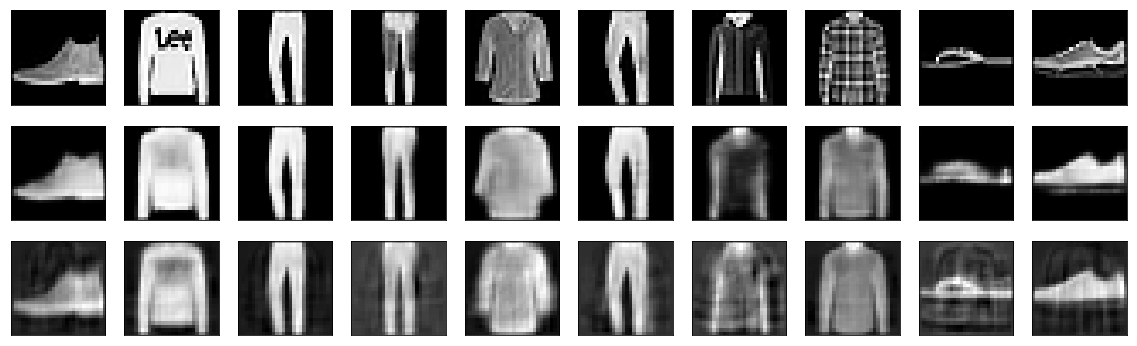

In [39]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    decoded_x_test = decoder.predict(H[i].reshape((1,128)))
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_x_test[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display linear approximation recontruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(X_linear_approx_test[i,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [17]:
np.linalg.norm(autoencoder.predict(x_test).reshape((10000, 28*28)) - X_linear_approx_test.reshape((10000, 28*28)))

237.07336

### Architecture from InfoGAN

In [12]:
latent_dim = 10

In [23]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(input_img)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(128, (4, 4), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
encoded = Dense(latent_dim)(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(1024)(encoded_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(6272)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Reshape((7,7,128))(x)
x = Conv2DTranspose(64, (4, 4), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
decoded = Conv2DTranspose(1, (4, 4), strides=(2,2), padding='same', activation='sigmoid')(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 128)         131200    
_________________________________________________________________
batch_normalization_16 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)              0         
__________

In [16]:
autoencoder.fit(x_train, x_train,
                epochs=1,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 471s 8ms/step - loss: 0.3160 - val_loss: 0.3086


In [28]:
8*10

80

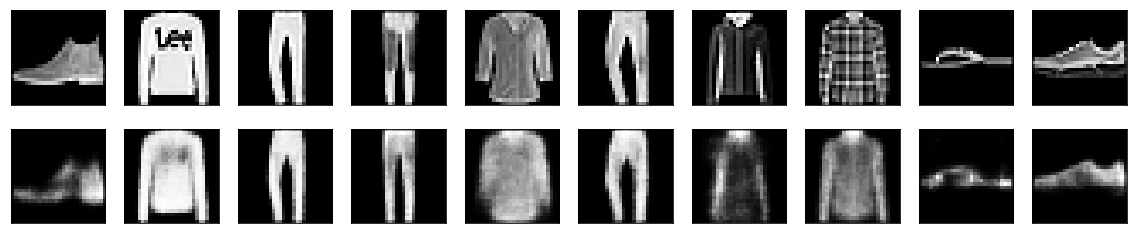

In [22]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    H = encoder.predict(x_test[i].reshape((1,28,28,1)))
    decoded_x_test = decoder.predict(H.reshape((1,10)))
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_x_test[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
plt.show()

In [19]:
x_test.shape

(10000, 28, 28, 1)

In [29]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 441s 7ms/step - loss: 0.3156 - val_loss: 0.2976
Epoch 2/10
60000/60000 [==============================] - 435s 7ms/step - loss: 0.2893 - val_loss: 0.2898
Epoch 3/10
60000/60000 [==============================] - 437s 7ms/step - loss: 0.2857 - val_loss: 0.2865
Epoch 4/10
60000/60000 [==============================] - 439s 7ms/step - loss: 0.2836 - val_loss: 0.2849
Epoch 5/10
60000/60000 [==============================] - 441s 7ms/step - loss: 0.2822 - val_loss: 0.2828
Epoch 6/10
60000/60000 [==============================] - 441s 7ms/step - loss: 0.2812 - val_loss: 0.2829
Epoch 7/10
60000/60000 [==============================] - 441s 7ms/step - loss: 0.2803 - val_loss: 0.2811
Epoch 8/10
60000/60000 [==============================] - 442s 7ms/step - loss: 0.2796 - val_loss: 0.2810
Epoch 9/10
60000/60000 [==============================] - 443s 7ms/step - loss: 0.2790 - val_loss: 0.2

In [3]:
31*50/60

25.833333333333332

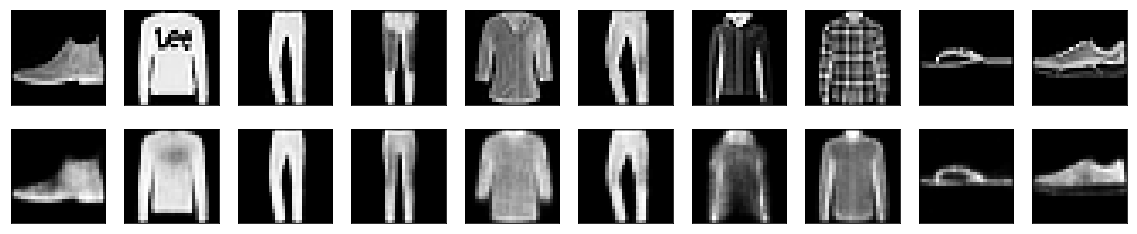

In [30]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    H = encoder.predict(x_test[i].reshape((1,28,28,1)))
    decoded_x_test = decoder.predict(H.reshape((1,10)))
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_x_test[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
plt.show()

In [2]:
46.50+31

77.5